# Prepare notebook

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from plotting_utilities import *

# Import data

In [2]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')

# Initial exploration of the data

In [3]:
genres = pd.get_dummies(books.goodreads_shelves.apply(pd.Series).stack()).sum(level=0)

In [4]:
top_genres = genres.sum().sort_values(ascending = False)[0:20].index

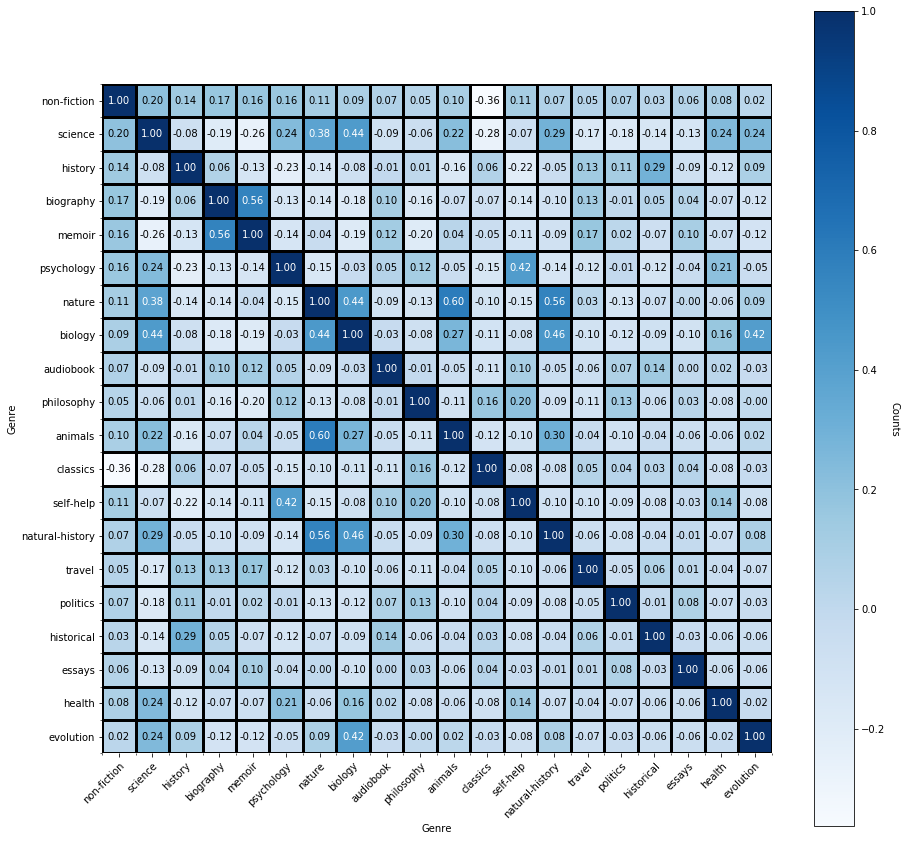

In [10]:
fig, ax = plt.subplots(1,1, figsize = (15,15))

im, cbar = heatmap(genres.corr().loc[top_genres, top_genres], 
                   row_title = 'Genre', row_labels= top_genres, 
                   col_title = 'Genre', col_labels = top_genres,
                   ax=ax, cmap='Blues', cbarlabel="Counts", 
                   x_tick_rotation = 45)
#cbar.remove()
cmv = im.get_array().data
texts = annotate_heatmap(im, data = cmv, valfmt="{x:.2f}")

In [11]:
books = books.join(genres)

In [74]:
genre_stats = {}
for c in genres.columns:
    gb = books.loc[books[c] == 1, 'My Rating']
    genre_stats[c] ={'count':len(gb),
                     'mean': gb.mean(),
                     'median': gb.median(),
                     'std':gb.std(),
                     'q1':gb.quantile(0.25),
                     'q3':gb.quantile(0.25),
                      5: sum(gb == 5),
                      4: sum(gb == 4),
                      3: sum(gb == 3),
                      2: sum(gb == 2),
                      1: sum(gb == 1),
                      0: sum(gb == 0),
                    }

genre_stats = pd.DataFrame(genre_stats).T 
genre_stats.index.name = 'genre'

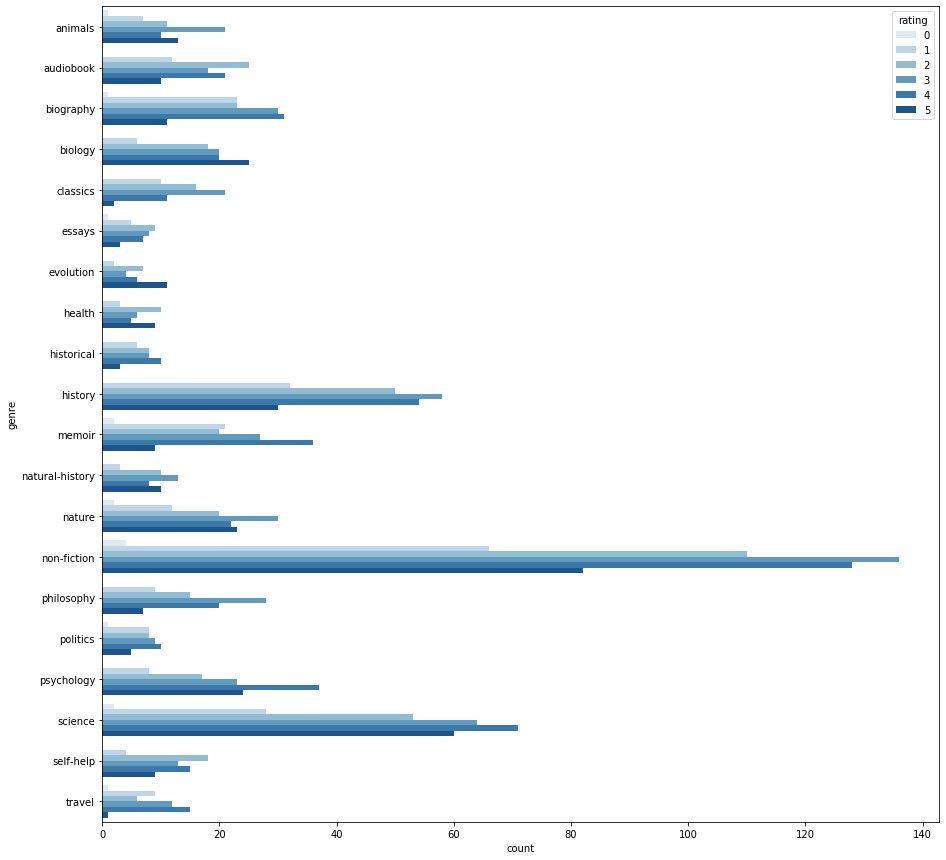

In [77]:
genre_rating_counts = pd.melt(genre_stats.reset_index(), 
                              id_vars=['genre'], value_vars=[5, 4, 3, 2, 1, 0],
                                var_name='rating', value_name='count')

fig, ax = plt.subplots(1,1, figsize = (15,15))
sns.barplot(data = genre_rating_counts.loc[genre_rating_counts.genre.apply(lambda s: s in top_genres)], 
                                           y = 'genre', x = 'count', hue = 'rating', 
            ax =ax, palette = 'Blues')

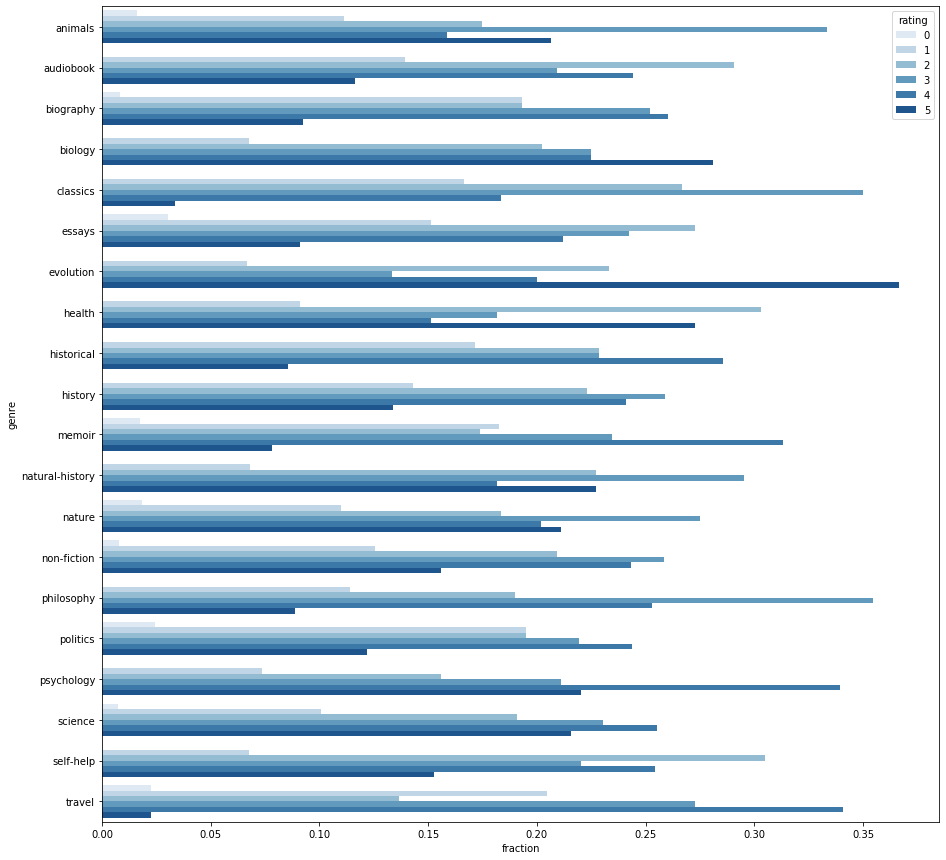

In [78]:
genre_rating_counts['fraction'] = genre_rating_counts.groupby('genre')['count'].transform(lambda g: g/genre_stats.loc[g.name, 'count'])


fig, ax = plt.subplots(1,1, figsize = (15,15))
sns.barplot(data = genre_rating_counts.loc[genre_rating_counts.genre.apply(lambda s: s in top_genres)], 
            y = 'genre', x = 'fraction', hue = 'rating', 
            ax =ax, palette = 'Blues')

In [86]:
rating_top_genres = {}
for rating, group in genre_rating_counts.groupby('rating'):
    group = group.sort_values('count', ascending = False)
    rating_top_genres[rating] = group.iloc[0:5][['genre', 'count']].set_index('genre').to_dict()['count']

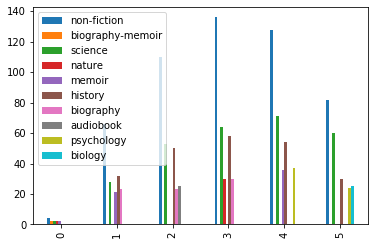

In [94]:
pd.DataFrame(rating_top_genres).T.plot.bar()